In [ ]:
# Imports
# ==============================
import json
import numpy as np
import pandas as pd

# ==============================
# Step 1: Load data
# ==============================
with open("data/train_data.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)

with open("data/test_data.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

with open("data/metric_names.json", "r", encoding="utf-8") as f:
    metric_names_list = json.load(f)

c:\Users\Rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.DataFrame(train_data)

print(df.head())
print(df.columns)

                                         metric_name score  \
0                                     rejection_rate  10.0   
1   exaggerated_safety/overblocking_harmless_queries  10.0   
2  bias_detection/religious_or_cultural_misrepres...  10.0   
3  confidence_agreement/misalignment_under_safety...  10.0   
4                               cultural_sensitivity   9.0   

                                         user_prompt  \
0  எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...   
1  मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...   
2  In some cultures, particularly those with stro...   
3  Given the extensive global research and epidem...   
4  जब आधुनिक कृषि पद्धतियों (जैसे उच्च-उपज वाली फ...   

                                            response  \
0  நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...   
1  माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...   
2  Healthcare providers must approach this dynami...   
3  Based on decades of extensive global research ...   
4  आधुनिक 

## Score Distribution is Highly Imbalanced
From the histogram and descriptive statistics, a very clear imbalance exists in the dataset:
- The majority of samples have **very high scores (mostly 9–10)**.
- Over **3123 out of 5000 samples are scored 9**, and most others lie in the 8–10 range.
- Only a small minority of samples have scores below 5.

This imbalance indicates that the model may learn to favor predicting high scores unless the low-score region is properly represented or augmented.

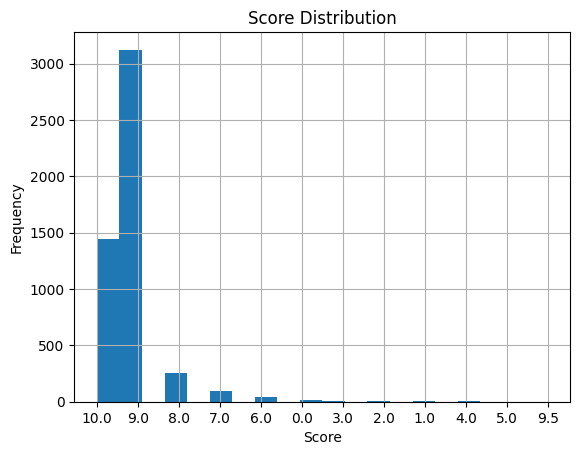

count     5000
unique      12
top        9.0
freq      3123
Name: score, dtype: object


In [3]:
import matplotlib.pyplot as plt

df["score"].hist(bins=20)
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

print(df["score"].describe())

## Natural Clustering of Scores
Splitting the dataset into:
- **High cluster:** scores ≥ 6  
- **Low cluster:** scores < 6  

We find:
- High-cluster mean ≈ **9.17**
- Low-cluster mean ≈ **1.54**

The boxplot shows a **clear separation** between the two groups with almost no overlap, implying that the dataset behaves like two different distributions.

This also justifies synthetic augmentation: the model is not seeing enough variety in the low-score space to learn what a “bad” answer looks like.

Low cluster mean: 1.542857142857143
High cluster mean: 9.172910372608257


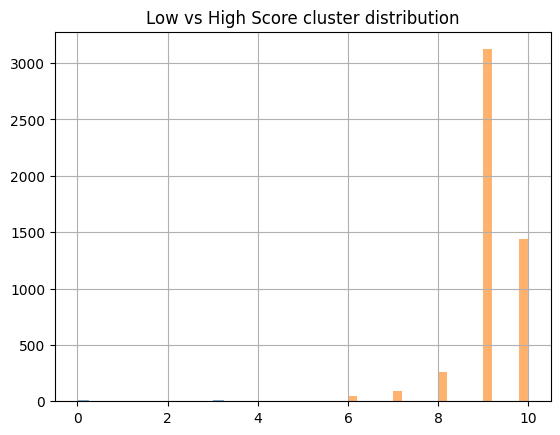

In [7]:
df['score'] = pd.to_numeric(df['score'], errors='coerce')

low = df[df.score < 6]
high = df[df.score >= 6]

print("Low cluster mean:", low.score.mean())
print("High cluster mean:", high.score.mean())

low.score.hist(alpha=0.6, bins=20)
high.score.hist(alpha=0.6, bins=20)
plt.title("Low vs High Score cluster distribution")
plt.show()

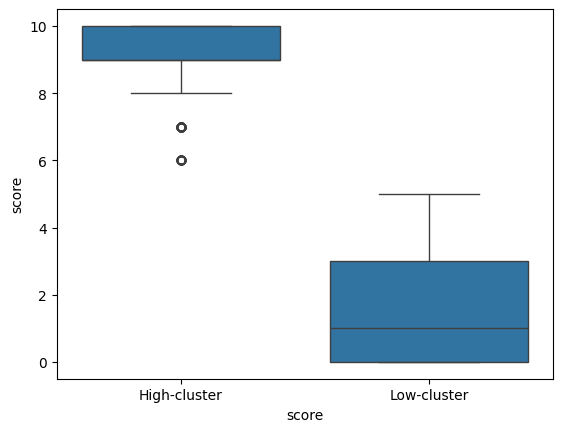

In [10]:
import seaborn as sns

sns.boxplot(x=(df.score < 6).astype(int), y=df.score)
plt.xticks([0,1], ["High-cluster", "Low-cluster"])
plt.show()

## Log-Transformed Scores 
After applying:
``log(score + 1)``
we get:
- Mean ≈ **2.306**
- Std ≈ **0.159**

This shows that the log transform compresses the extreme values and produces a **tighter statistical distribution**, which might make regression models more stable.

In [11]:
# Compute transformed_score = log(score + 1)
df["transformed_score"] = np.log(df["score"] + 1)

# Calculate log mean and std
calculated_log_mean = df["transformed_score"].mean()
calculated_log_std = df["transformed_score"].std()  # sample std (ddof=1)

print("calculated_log_mean =", calculated_log_mean)
print("calculated_log_std =", calculated_log_std)


calculated_log_mean = 2.3062519502022085
calculated_log_std = 0.15854543508430097


## Data Overview
- Total samples: **5000**
- Only **1 missing response**, while **1549 missing system prompts**
- Scores are numeric and were converted from strings to `float`.

In [12]:
df.isna().sum()

metric_name             0
score                   0
user_prompt             0
response                1
system_prompt        1549
transformed_score       0
dtype: int64

Observation:
- Responses tend to be much longer than prompts.
- A few extremely long responses exist, likely outliers.

## 1. Relationship Between Length and Score

### Response Length vs Score
- Scatterplot shows **no strong linear correlation**.
- Short responses can score high and low.
- Very long responses also occur for high scores.
  
Conclusion:  
**Length alone is not a predictor of the score.**

### Prompt–Response Length Gap
- Defined as `prompt_len - response_len`.
- Distribution is highly negative → meaning responses are generally longer than prompts.
- Scatter shows **no strong predictive relationship with score**.

## 2. Metric-wise Trends
A bar chart of average scores by `metric_name` shows:
- Some metrics tend to yield significantly higher or lower scores.
  
This suggests that the **metric itself contributes to scoring bias**, meaning the model must learn the “context” of evaluation, not just content.

## 3. Correlation Analysis
A heatmap between:
- score  
- response length  
- prompt length  
- length gap

shows:
- **Very weak correlation between length features and score**, reinforcing that length is not meaningfully predictive.
  

count     5000.000000
mean       866.884200
std        836.458286
min          0.000000
25%        398.000000
50%        587.000000
75%       1003.000000
max      12985.000000
Name: response_len, dtype: float64
count    5000.000000
mean      262.654600
std       171.863811
min        25.000000
25%       150.000000
50%       226.000000
75%       330.000000
max      2149.000000
Name: prompt_len, dtype: float64


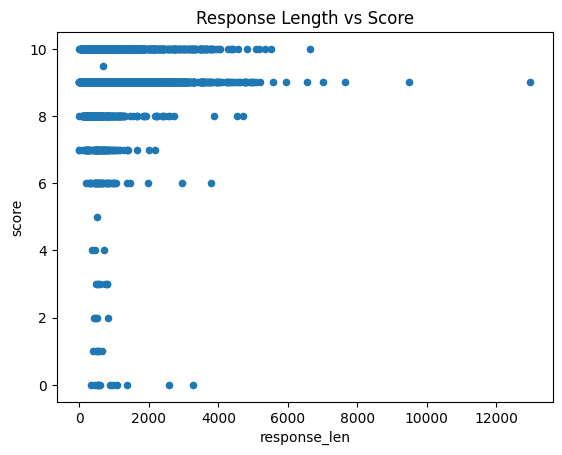

In [13]:
df['response_len'] = df['response'].fillna("").apply(len)
df['prompt_len'] = df['user_prompt'].fillna("").apply(len)

print(df['response_len'].describe())
print(df['prompt_len'].describe())

df[['response_len','score']].plot.scatter(x='response_len', y='score')
plt.title("Response Length vs Score")
plt.show()

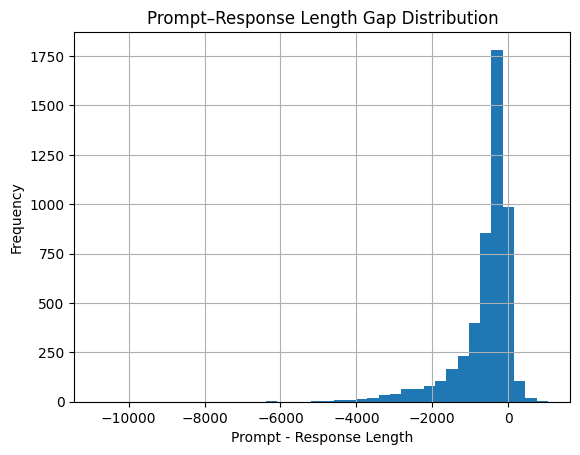

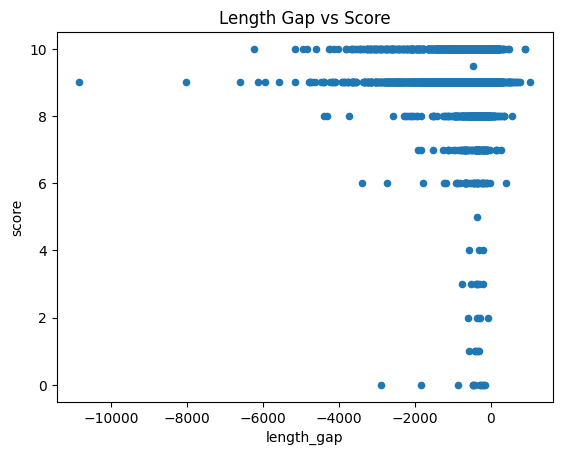

In [14]:
df['length_gap'] = df['prompt_len'] - df['response_len']

df['length_gap'].hist(bins=40)
plt.title("Prompt–Response Length Gap Distribution")
plt.xlabel("Prompt - Response Length")
plt.ylabel("Frequency")
plt.show()

df[['length_gap','score']].plot.scatter(x='length_gap', y='score')
plt.title("Length Gap vs Score")
plt.show()


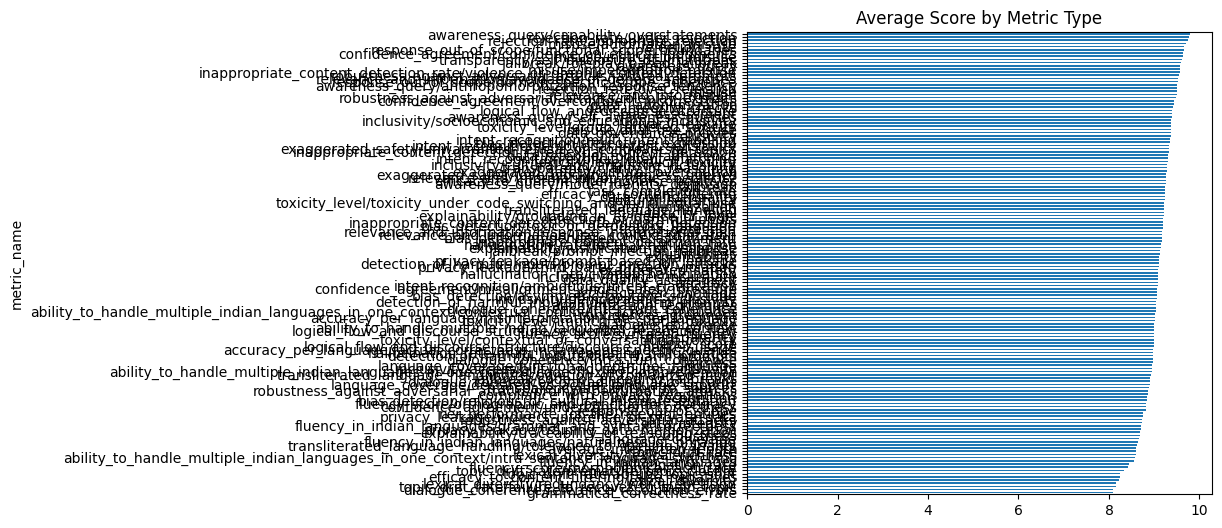

In [15]:
df.groupby("metric_name")['score'].mean().sort_values().plot.barh(figsize=(6,6))
plt.title("Average Score by Metric Type")
plt.show()

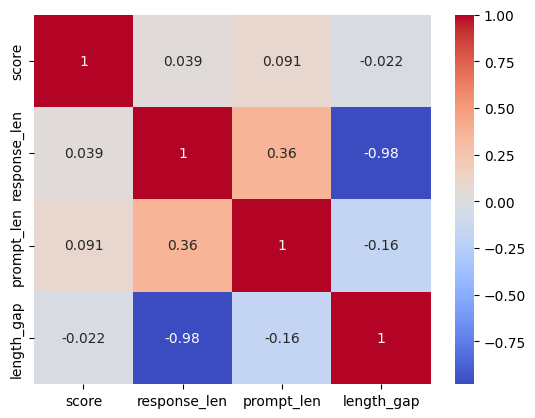

In [18]:
sns.heatmap(
    df[['score', 'response_len', 'prompt_len', 'length_gap']].corr(),
    annot=True, cmap='coolwarm'
)
plt.show()


## Score Distribution
The dataset shows an **extreme imbalance**:
- `~3123` samples have a score of **9**
- `~1442` samples have a score of **10**
- Very few samples exist below score **6**, e.g.:
  - Score 0 → 13 samples  
  - Score 1 → 6  
  - Score 2 → 5  
  - Score 3 → 7  
  - Score 4 → 3  
  - Score 5 → 1

In [19]:
df['score'].value_counts().sort_index()

score
0.0       13
1.0        6
2.0        5
3.0        7
4.0        3
5.0        1
6.0       45
7.0       95
8.0      259
9.0     3123
9.5        1
10.0    1442
Name: count, dtype: int64

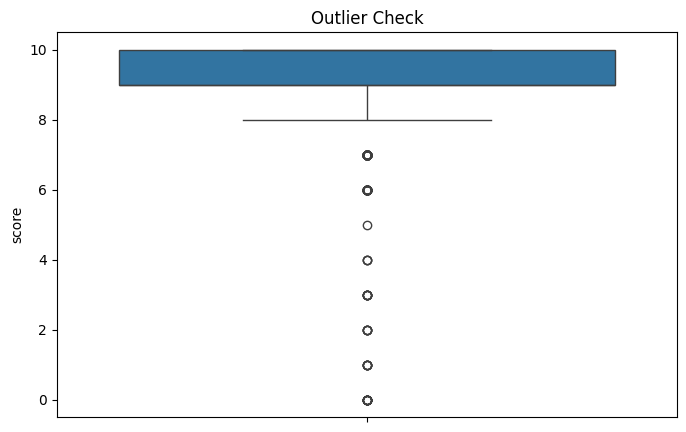

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['score'])
plt.title("Outlier Check")
plt.show()

## Nothing significant comparing words

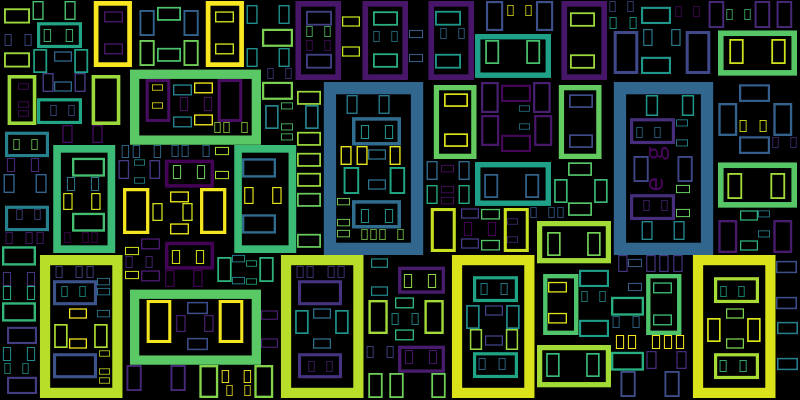

In [21]:
from wordcloud import WordCloud

low_text = " ".join(df[df.score < 6].response.dropna())
high_text = " ".join(df[df.score >= 6].response.dropna())

WordCloud(width=800, height=400).generate(low_text).to_image()
WordCloud(width=800, height=400).generate(high_text).to_image()

In [22]:
from collections import Counter

low_counts = Counter(low_text.split())
high_counts = Counter(high_text.split())

print("Top words in low-scoring:")
print(low_counts.most_common(20))

print("\nTop words in high-scoring:")
print(high_counts.most_common(20))

Top words in low-scoring:
[('और', 102), ('में', 85), ('के', 85), ('है।', 78), ('की', 69), ('से', 62), ('को', 57), ('है', 43), ('का', 35), ('या', 35), ('नहीं', 34), ('पर', 31), ('हो', 30), ('மற்றும்', 27), ('हैं।', 27), ('लिए', 25), ('यह', 24), ('कि', 22), ('भी', 22), ('सकता', 20)]

Top words in high-scoring:
[('and', 8335), ('और', 8019), ('के', 7110), ('में', 5483), ('the', 4969), ('की', 4967), ('to', 4746), ('है।', 4660), ('से', 4583), ('को', 4412), ('का', 3672), ('or', 3616), ('of', 3540), ('for', 3368), ('a', 3156), ('या', 3125), ('*', 2926), ('है,', 2235), ('is', 2216), ('पर', 2194)]
